In [1]:
import rdflib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx

from knowledge_graph import *
from rdf2vec import RDF2VecTransformer
from LCS import new_lcs
from rdf_graph_utils import rdf_to_plot, rdf_to_text

In [2]:
print(end='Loading data... ', flush=True)
g = rdflib.Graph()
g.parse('data/new_limit_500k.nt', format="nt")
print('OK')

# URI DI TUTTE LE DRUGS
all_drugs_file = pd.read_csv('data/all_drugs.tsv', sep='\t')
all_drugs = [rdflib.URIRef(x) for x in all_drugs_file['drug']]

# PREDICATI DA ESCLUDERE NELL'ESTRAZIONE DEL GRAFO
predicates = pd.read_csv('data/bad_predicates.tsv', sep='\t')
predicates = [rdflib.URIRef(x) for x in predicates['predicate']]

Loading data... OK


In [4]:
# TRASFORMAZIONE DELL'INTERO GRAFO IN KNOWLEDGE GRAPH (contenente matrice di adiacenze, necessario per rdf2vec)
kg = rdflib_to_kg(g, label_predicates=predicates)

In [5]:
# PER OGNI DRUG VIENE ESTRATTO IL SUB-GRAPH SE PRESENTE NELLA NOSTRO KB
i = 1
j = 1

kv = []
drugs = []
graphs = []
for drug in all_drugs:
    try:
        g = extract_instance(kg, drug)
        graphs.append(g)
        drugs.append(drug)
        kv.append( {'graph': g, 'resource': drug} )
        i += 1
    except Exception as e:
        j += 1
        
print('ok:' + str(i))
print('failed:' + str(j))

ok:503
failed:7258


In [6]:
# ESTRAZIONE DEGLI EMBEDDINGS TRAMITE RDF2VEC E CLUSTERING
# Embeddings
transformer = RDF2VecTransformer(_type='walk', walks_per_graph=500)
embeddings = transformer.fit_transform(graphs)

# Clustering
kmeans = KMeans(n_clusters=7)
k = kmeans.fit(embeddings)
y_kmeans = kmeans.predict(embeddings)

502it [00:07, 69.02it/s] 


In [8]:
# STAMPO PER OGNI RISORSA IL CLUSTER A CUI CORRISPONDE, IN MODO DA POTERNE PRELEVARE PER IL MOMENTO
# DUE APPARTENENTI ALLO STESSO CLUSTER
k = 0
for y in y_kmeans:
    print(str(k) + ': ' + str(y))
    k += 1

0: 1
1: 1
2: 1
3: 2
4: 5
5: 3
6: 6
7: 6
8: 6
9: 5
10: 5
11: 4
12: 5
13: 1
14: 4
15: 3
16: 0
17: 0
18: 1
19: 3
20: 6
21: 2
22: 5
23: 6
24: 2
25: 4
26: 6
27: 5
28: 3
29: 3
30: 4
31: 5
32: 4
33: 5
34: 5
35: 5
36: 5
37: 5
38: 0
39: 5
40: 2
41: 6
42: 4
43: 3
44: 4
45: 4
46: 5
47: 6
48: 5
49: 3
50: 3
51: 0
52: 2
53: 0
54: 5
55: 5
56: 5
57: 3
58: 0
59: 6
60: 0
61: 6
62: 5
63: 3
64: 3
65: 3
66: 4
67: 6
68: 5
69: 0
70: 3
71: 5
72: 5
73: 6
74: 4
75: 4
76: 2
77: 6
78: 4
79: 5
80: 3
81: 3
82: 3
83: 0
84: 6
85: 4
86: 0
87: 6
88: 6
89: 6
90: 3
91: 3
92: 4
93: 2
94: 5
95: 5
96: 6
97: 5
98: 0
99: 3
100: 0
101: 5
102: 0
103: 5
104: 5
105: 1
106: 3
107: 4
108: 6
109: 5
110: 4
111: 1
112: 5
113: 5
114: 5
115: 5
116: 5
117: 5
118: 5
119: 5
120: 5
121: 5
122: 4
123: 0
124: 2
125: 4
126: 3
127: 3
128: 5
129: 2
130: 0
131: 6
132: 5
133: 6
134: 6
135: 5
136: 6
137: 4
138: 4
139: 5
140: 0
141: 6
142: 5
143: 6
144: 6
145: 5
146: 6
147: 6
148: 3
149: 5
150: 5
151: 3
152: 3
153: 3
154: 3
155: 3
156: 5
157: 5
158:

In [9]:
# SELEZIONO I GRAFI RELATIVI A DUE DRUGS RISULTANTI NELLO STESSO CLUSTER
drug1 = drugs[6]
drug2 = drugs[8]

graph1 = graphs[6]
graph2 = graphs[8]

print(drug1)
#graph1.visualise()
print(drug2)
#graph2.visualise()


http://bio2rdf.org/drugbank:DB08420
http://bio2rdf.org/drugbank:DB08422


In [10]:
# ESTRAZIONE DI UNINFORMATIVE TRIPLES E STOPPING PATTERNS DAI FILE
preds = pd.read_csv('data/uninformative.tsv', sep='\t')
preds = [rdflib.URIRef(x) for x in preds['uninformative']]

stop_patterns = pd.read_csv('data/stop_patterns.tsv', sep='\t')
stop_patterns = [x for x in stop_patterns['stopping_patterns']]

In [11]:
# CREAZIONE DEL GRAFO OTTENUTO DAL LCS
rdflib_x_Tx = new_lcs(graph1, graph2, depth=2, stop_patterns=stop_patterns, uninformative_triples=preds)

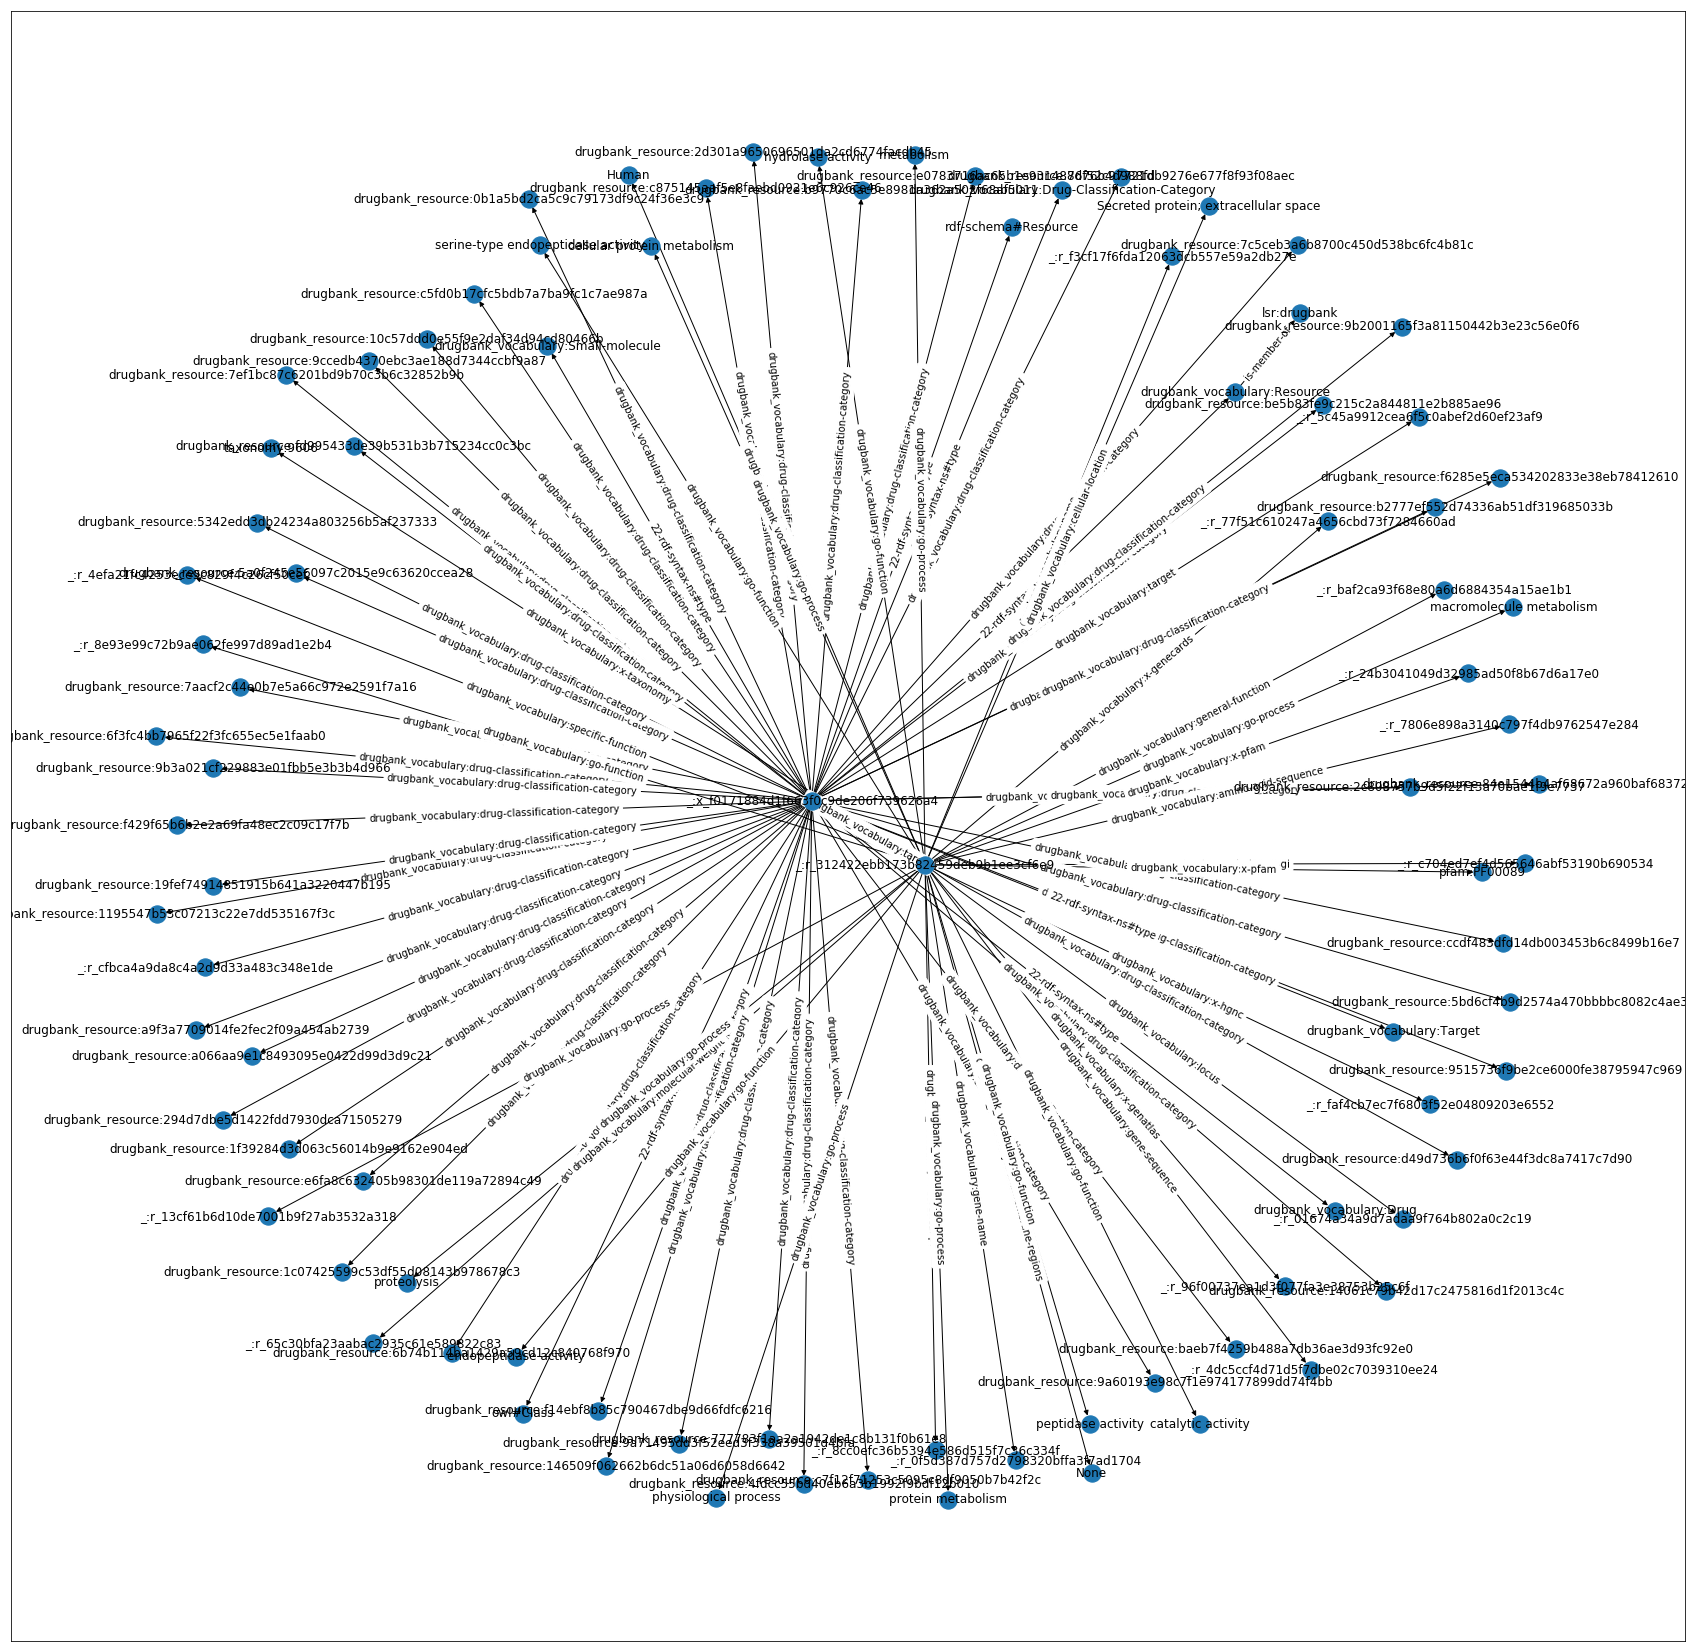

b'"_:x_f0171884d1f663f0c9de206f739626a4" <http://bio2rdf.org/drugbank_vocabulary:drug-classification-category> <http://bio2rdf.org/drugbank_resource:c5fd0b17cfc5bdb7a7ba9fc1c7ae987a> .\n"_:x_f0171884d1f663f0c9de206f739626a4" <http://bio2rdf.org/drugbank_vocabulary:drug-classification-category> <http://bio2rdf.org/drugbank_resource:a066aa9e1c8493095e0422d99d3d9c21> .\n"_:x_f0171884d1f663f0c9de206f739626a4" <http://bio2rdf.org/drugbank_vocabulary:drug-classification-category> <http://bio2rdf.org/drugbank_resource:b9770c6ac5e8981a362a502f68af5011> .\n"_:x_f0171884d1f663f0c9de206f739626a4" <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://bio2rdf.org/drugbank_vocabulary:Drug-Classification-Category> .\n"_:r_312422ebb173b82459deb9b1ee3cf6e9" <http://bio2rdf.org/drugbank_vocabulary:go-function> "_:r_8e93e99c72b9ae062fe997d89ad1e2b4" .\n"_:r_312422ebb173b82459deb9b1ee3cf6e9" <http://bio2rdf.org/drugbank_vocabulary:x-taxonomy> <http://bio2rdf.org/taxonomy:9606> .\n"_:x_f0171884d1f663f0

In [14]:
# RAPPRESENTAZIONE GRAFICA IN PLOT DEL GRAFO
rdf_to_plot(rdflib_x_Tx)

# SALVATAGGIO DEL GRAFO IN FORMATO 'NT'
rdf_to_text(rdflib_x_Tx, 'data/outputs', 'nt')

In [ ]:
# ESTRAZIONE DELLE COMPONENTI PRINCIPALI PER POTER RAPPRESENTARE GRAFICAMENTE LA DISTINZIONE IN CLUSTER 
# 2 PC -> RAPPRESENTAZIONE 2D
# 3 PC -> RAPPRESENTAZIONE 3D

# PCA (2)
pca = PCA(n_components=2)
pca = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(data=pca, columns=['pc1', 'pc2'])

In [ ]:
# KMEANS SU LE 2 PC PER POTER INDIVIDUARE I PUNTI CENTRALI PER LA RAPPRESENTAZIONE GRAFICA (STEP NON NECESSARIO)
kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(principalDf)

In [ ]:
# rappresentazione grafica
plt.scatter(principalDf['pc1'], principalDf['pc2'], c=y_kmeans, s=50, cmap='viridis')

centers = np.asarray(kmeans2.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

In [ ]:
# PCA (3)
pca = PCA(n_components=3)
pca = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(data=pca, columns=['pc1', 'pc2', 'pc3'])

kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(principalDf)

In [ ]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(principalDf['pc1'], principalDf['pc2'], principalDf['pc3'], c=y_kmeans, s=50, cmap='viridis')

centers = np.asarray(kmeans2.cluster_centers_)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c='black', s=200, alpha=0.5)